In [15]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

In [16]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction='in')
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction='in') 

        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [17]:
df = pd.read_csv('FP_CF4_components_bar.csv', delimiter='|')
df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)
df = df.set_index('PGC')

print(len(df))

df.head()

38370


,PGC1,Nest,Vcmb,Vmod,DM_av,eDM_av,av_flag,DM_6dfgs,eDM_6dfgs,6dfgs_flag,...,fpsdss_flag,DM_smc,eDM_smc,smc_flag,DM_enr,eDM_enr,enr_flag,DM_far,eDM_far,far_flag
PGC,,,,,,,,,,,,,,,,,,,,,
64,72642.0,200033.0,15324.0,15938.430745,36.734697,0.629727,0.0,36.734697,0.629727,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,72642.0,200033.0,14725.0,15292.703769,36.405167,0.586298,0.0,36.405167,0.586298,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,72642.0,200033.0,14397.0,14939.887452,35.629032,0.586298,0.0,35.629032,0.586298,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115,115.0,0.0,14005.0,14518.945116,36.376557,0.586298,0.0,36.376557,0.586298,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,123.0,205549.0,10966.0,11282.137786,36.023313,0.564583,0.0,36.023313,0.564583,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

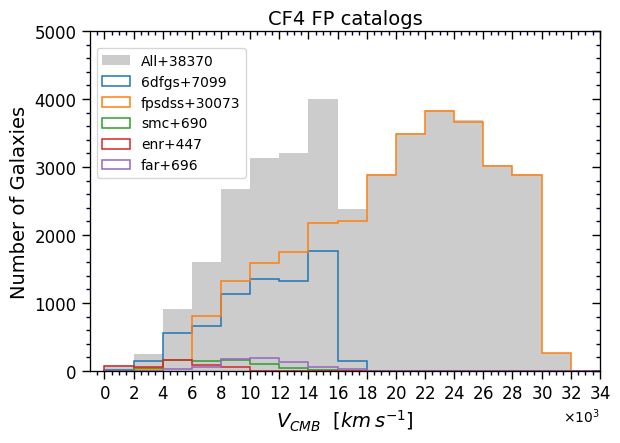

In [19]:
fig = plt.figure(figsize=(6, 4), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])

bins=np.arange(0,36000,2000)

val = df.Vcmb.values
ax.hist(val, bins=bins, histtype='bar', label='All+'+str(len(val)), color='k', lw=1.7, alpha=0.2) 

val = df[df["DM_6dfgs"]!=0]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='6dfgs+'+str(len(val)), lw=1.1) 

val = df[df["DM_fpsdss"]!=0]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='fpsdss+'+str(len(val)), lw=1.1)

val = df[df["DM_smc"]!=0]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='smc+'+str(len(val)), lw=1.1) 

val = df[df["DM_enr"]!=0]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='enr+'+str(len(val)), lw=1.1) 

val = df[df["DM_far"]!=0]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='far+'+str(len(val)), lw=1.1) 


x_ax, y_ax = set_axes(ax, [-1000,34000], [0,5000], fontsize=12, inout='out')


ax.set_xlabel(r"$V_{CMB}$"+"  "+r'$[km \/ s^{-1}]$', fontsize=14)
ax.set_ylabel("Number of Galaxies", fontsize=14)

ax.legend(bbox_to_anchor=(0.32, 0.97), loc='upper right', fontsize=10)

x_ax.set_xticks(np.arange(0, 36000, step=2000))
ax.set_xticks(np.arange(0, 36000, step=2000))


ax.set_title("CF4 FP catalogs", fontsize=14, pad=5)

ax.xaxis.set_major_formatter(OOMFormatter(3, "%d"))
ax.ticklabel_format(axis='x', style='sci')

In [20]:
leda = pd.read_csv('Leda_bar.csv', delimiter='|')
leda = leda.set_index('PGC')

print(len(leda))

397843


In [21]:
how = 'inner'

print(len(df))

df = df.join(leda, lsuffix='_6dfgs', rsuffix='_leda', how=how)
df = df[["PGC1", "Vcmb", "sgl", "sgb"]]


# df = df.rename(columns={"Vcmb_cf4":"Vcmb"})
df = df.astype({"PGC1": int})


print(len(df))

df.head()

38370
38367


,PGC1,Vcmb,sgl,sgb
PGC,,,,
64,72642,15324.0,350.79821,-76.15927
66,72642,14725.0,350.30837,-76.07823
114,72642,14397.0,348.86939,-75.99113
115,115,14005.0,93.26871,-64.31866
123,123,10966.0,77.28853,-73.03426


In [22]:
dg = df.groupby('PGC1').agg(["mean", "count"])

dg.head()

Vcmb               sgl              sgb      
              mean count        mean count       mean count
PGC1                                                       
75    11619.800000     5  330.592874     5 -70.527476     5
115   14005.000000     1   93.268710     1 -64.318660     1
123   10966.000000     1   77.288530     1 -73.034260     1
211   10550.142857     7  317.466283     7 -61.723701     7
262    8795.000000     1  330.106360     1 -70.910070     1

In [23]:
dg.loc[115].Vcmb['count']

1.0

In [24]:
df["Vgrp"] = df["PGC1"].apply(lambda x: dg.loc[x].Vcmb['mean'])
df["Ngrp"] = df["PGC1"].apply(lambda x: dg.loc[x].Vcmb['count'])

df.head()

,PGC1,Vcmb,sgl,sgb,Vgrp,Ngrp
PGC,,,,,,
64,72642,15324.0,350.79821,-76.15927,13983.272727,11.0
66,72642,14725.0,350.30837,-76.07823,13983.272727,11.0
114,72642,14397.0,348.86939,-75.99113,13983.272727,11.0
115,115,14005.0,93.26871,-64.31866,14005.000000,1.0
123,123,10966.0,77.28853,-73.03426,10966.000000,1.0


In [25]:
df = df.sort_values(by=['Vgrp', 'PGC1'], ascending=False)

print(len(df))

df.head(20)

38367


,PGC1,Vcmb,sgl,sgb,Vgrp,Ngrp
PGC,,,,,,
1335861,1335861,30330.0,257.45052,64.18731,30330.0,1.0
1102190,1102190,30314.0,282.30445,59.10783,30314.0,1.0
3469289,3469289,30311.0,241.35480,57.96814,30311.0,1.0
3358313,3358313,30306.0,244.53493,50.91030,30306.0,1.0
3121326,3121326,30305.0,266.16348,60.29641,30305.0,1.0
1217037,1217037,30303.0,262.79751,58.77888,30303.0,1.0
1231857,1231857,30298.0,232.13292,37.48905,30298.0,1.0
3461155,3461155,30296.0,226.82549,43.86821,30296.0,1.0
3113849,3113849,30294.0,280.79314,61.26580,30294.0,1.0


In [26]:
cols = [x for x in df.columns]

print(len(df))

df.head()

38367


,PGC1,Vcmb,sgl,sgb,Vgrp,Ngrp
PGC,,,,,,
1335861,1335861,30330.0,257.45052,64.18731,30330.0,1.0
1102190,1102190,30314.0,282.30445,59.10783,30314.0,1.0
3469289,3469289,30311.0,241.35480,57.96814,30311.0,1.0
3358313,3358313,30306.0,244.53493,50.91030,30306.0,1.0
3121326,3121326,30305.0,266.16348,60.29641,30305.0,1.0


In [28]:
vel = df.Vcmb.values
vel = df.Vgrp.values

# vel = (vel-np.min(vel)) / (np.max(vel)-np.min(vel)) + 1
# vel = np.log10(vel)
# Mvel = np.median(vel)
# vel = vel / Mvel / 2.

print(np.min(vel), np.max(vel))


(1049.0, 30330.0)


(array([ 296., 1352., 3655., 4571., 5357., 3725., 4934., 5455., 5025.,
        3997.]),
 array([ 1049. ,  3977.1,  6905.2,  9833.3, 12761.4, 15689.5, 18617.6,
        21545.7, 24473.8, 27401.9, 30330. ]),
 <a list of 10 Patch objects>)

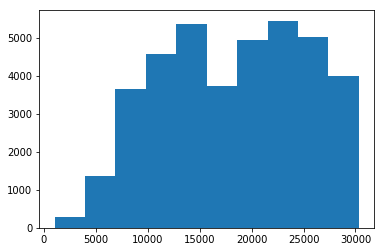

In [29]:
plt.hist(vel)

In [30]:
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

In [31]:
df.columns

Index([u'PGC1', u'Vcmb', u'sgl', u'sgb', u'Vgrp', u'Ngrp'], dtype='object')

In [32]:
import copy

df_all = copy.deepcopy(df)



In [33]:
import sys
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import  lines
from matplotlib import rc, rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Polygon, Ellipse
import numpy as np
from math import *
from time import time
import wl_to_rgb as col
import random
from astropy.io import ascii
from astropy.table import Table, Column 
import pyfits
import pylab as py
from astropy import coordinates as coord
from astropy import units as unit
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.patches as mpatches

from matplotlib import *

/home/ehsan/anaconda3/envs/py2/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [34]:
df = df_all[df_all["Vgrp"]<16000]

vel = df.Vcmb.values
vel = df.Vgrp.values

print np.min(vel), np.max(vel)


1049.0 15999.0


In [35]:
len(df)

15881

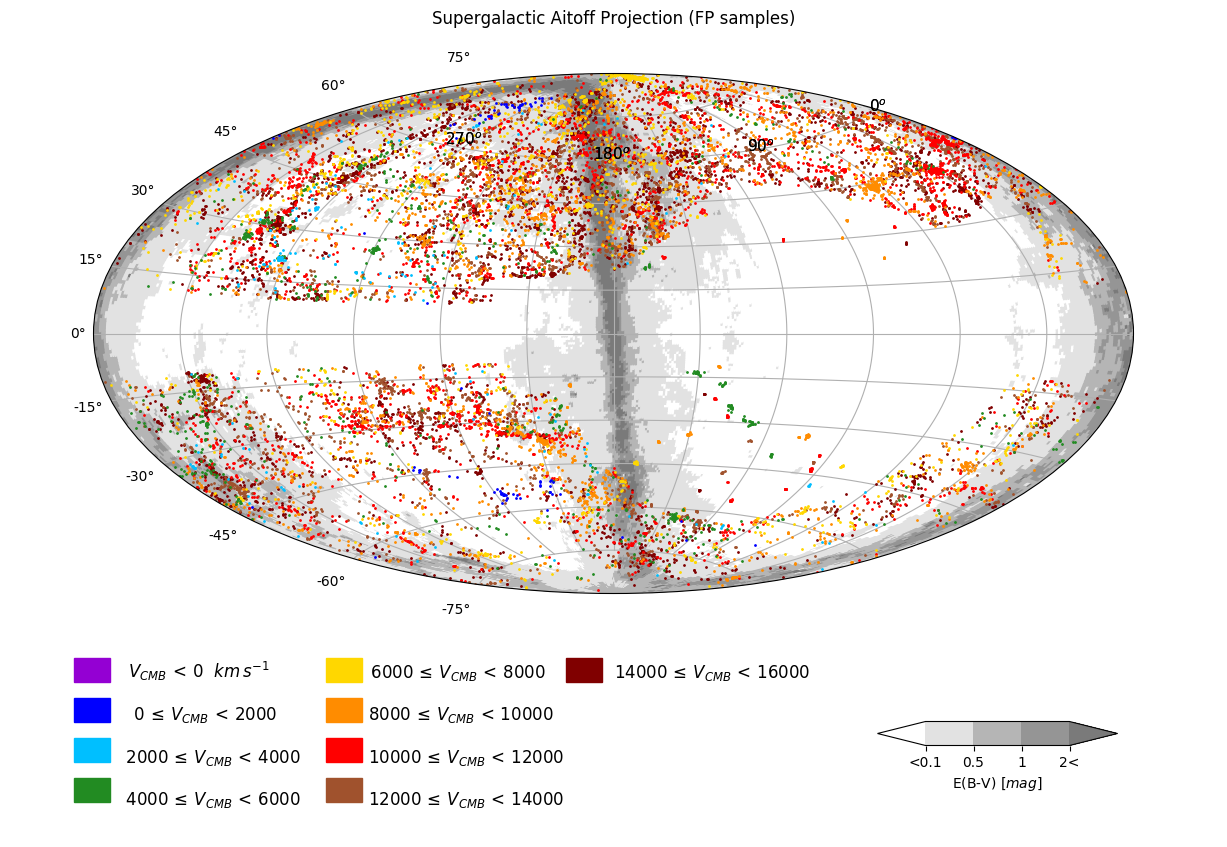

In [36]:
l0 = 180

deg = 0.8
a = pyfits.open('EBV.0.8.deg.fits')
d = a[1].data

SGL  = d['SGL']
SGB  = d['SGB']
EBV = d['EBV']

fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection="aitoff")
plt.title("Supergalactic Aitoff Projection (FP samples)", y=1.08)
ax.grid(True)
ax.set_xticklabels([])
plt.subplots_adjust(top=0.95, bottom=0.3, right=0.95, left=0.05)

ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')


ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')  
################################################################ 
################################################################ 
def xymap_aitoff(x, y):
  
    while x > 360:
        x-=360
    while x < 0:
        x+=360

    x0 = (180.-x)*pi/180.
    y0 = y*pi/180.
  
    return x0, y0
################################################################ 

def esn_aitoff_patch(ax, x0, y0, d, color='blue'):

    vertices = []
    x, y = xymap_aitoff(x0,y0) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0) 
    vertices.append([x,y]) 
    ax.add_patch(Polygon(vertices, closed=True, fill=True, color=color))


jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(len(SGB)):
    if EBV[i]>2.0: val = 3
    elif EBV[i]>1.0: val = 2.5
    elif EBV[i]>0.5: val= 2.0
    elif EBV[i]<=0.5 and EBV[i]>0.1: val= 1.0
    elif EBV[i]<0.1: val= 0
    else: val= 0
    colorVal = scalarMap.to_rgba(val)
    esn_aitoff_patch(ax, SGL[i], SGB[i], deg, color=colorVal)

    
    
# N = len(SGL)
# X = np.zeros(N)
# Y = np.zeros(N)
# for i in range(N):
#     X[i], Y[i] = xymap_aitoff(SGL[i], SGB[i])    
# ax.scatter(X, Y, marker='.', color='black')


sgl_gal = df.sgl.values
sgb_gal = df.sgb.values
N = len(sgl_gal)
X = np.zeros(N)
Y = np.zeros(N)
for i in range(N):
    X[i], Y[i] = xymap_aitoff(sgl_gal[i], sgb_gal[i])
    
############################################
    
# vel_col = np.zeros(N)   
# Velocity = df.Vcmb.values
# for i, v in enumerate(vel):
#     vel_col[i] = 0
#     if v<=0:
#         vel_col[i] = 0.1
#     elif v>=11000:
#         vel_col[i] = 1
#     else:
#         vel_col[i] = 0.1+0.9*v/11000.
    
# colours = pl.cm.nipy_spectral(vel_col)

############################################
col_pallet = ['darkviolet', 'blue', 'deepskyblue', 'forestgreen', 'gold', 'darkorange', 'red', 'sienna', 'maroon']
vel_pallet = [-100000, 0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000]
def color_table(Velocity):
    colours = []
    for j, v in enumerate(Velocity):
        col = "white"
        for i in range(len(vel_pallet)-1):
            if vel_pallet[i] <= v and v < vel_pallet[i+1]:
                col = col_pallet[i]
                break
        colours.append(col)
    return colours

colours = color_table(df.Vgrp.values)
############################################

ax2 = plt.axes([0,0,1,1], facecolor=(1,1,1,0))
ax2.set_axis_off()
ax2.set_xticks([])
ax2.set_yticks([])
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.annotate(r"$\/\/ V_{CMB} \/ < \/ 0 \/\/\/\/ km\/ s^{-1}  $", (0.1,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$ \/\/\/\/ 0 \/ \leq \/ V_{CMB} \/ < \/ 2000$', (0.1,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 2000 \/ \leq \/ V_{CMB} \/ < \/ 4000$', (0.1,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 4000 \/ \leq \/ V_{CMB} \/ < \/ 6000$', (0.1,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 6000 \/ \leq \/ V_{CMB} \/ < \/ 8000$', (0.30,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$8000 \/ \leq \/ V_{CMB} \/ < \/ 10000$', (0.30,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$10000 \/ \leq \/ V_{CMB} \/ < \/ 12000$', (0.30,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$12000 \/ \leq \/ V_{CMB} \/ < \/ 14000$', (0.30,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$14000 \/ \leq \/ V_{CMB} \/ < \/ 16000$', (0.5,0.2), xycoords='figure fraction', size=12, color='black')
# ax2.annotate(r'$16000 \/ \leq \/ V_{CMB}$', (0.50,0.2-0.05), xycoords='figure fraction', size=12, color='black')

try:
    p = 0
    for m in [0.1,0.31,0.51]:
        for n in [0.19,0.19-0.05,0.19-2*0.05,0.19-3*0.05]:
            ax2.add_patch(patches.Rectangle((m-0.05, n), 0.03, 0.03, color=col_pallet[p]))
            p+=1
    # ax2.add_patch(patches.Rectangle((0.71-0.05, 0.19), 0.03, 0.03, color=col_pallet[p]))
except:
    pass
############################################
################################################################ 
jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
ax3 = fig.add_axes([0.720, 0.11, 0.2, 0.03])
cols = []
bounds = [0,1,2,3]
#cols.append(scalarMap.to_rgba(0))
cols.append(scalarMap.to_rgba(1.0))
cols.append(scalarMap.to_rgba(2.0))
cols.append(scalarMap.to_rgba(2.5))
#cols.append(scalarMap.to_rgba(3.0))


cm = colors.ListedColormap(cols)

cm.set_over(scalarMap.to_rgba(3.0))
cm.set_under(scalarMap.to_rgba(0))

cNorm  = colors.BoundaryNorm(bounds, cm.N)
cbar = colorbar.ColorbarBase(ax3, cmap=cm, norm=cNorm, orientation='horizontal',ticks=bounds, boundaries=[-1]+bounds+[4],extend='both',extendfrac='auto')
cbar.set_ticks(bounds)
cbar.ax.tick_params(labelsize=10) 
cbar.ax.set_xticklabels(['<0.1','0.5','1','2<'])  # horizontal colorbar

cbar.set_label('E(B-V) '+r'$[mag]$')
################################################################   

for i, c in enumerate(colours):
    ax.plot([X[i]], [Y[i]], color=c, marker='.', ms=2)
    

In [37]:
df = df_all[df_all["Vgrp"]>=16000]

vel = df.Vcmb.values
vel = df.Vgrp.values

print np.min(vel), np.max(vel)


16000.0 30330.0


In [38]:
len(df)

22486

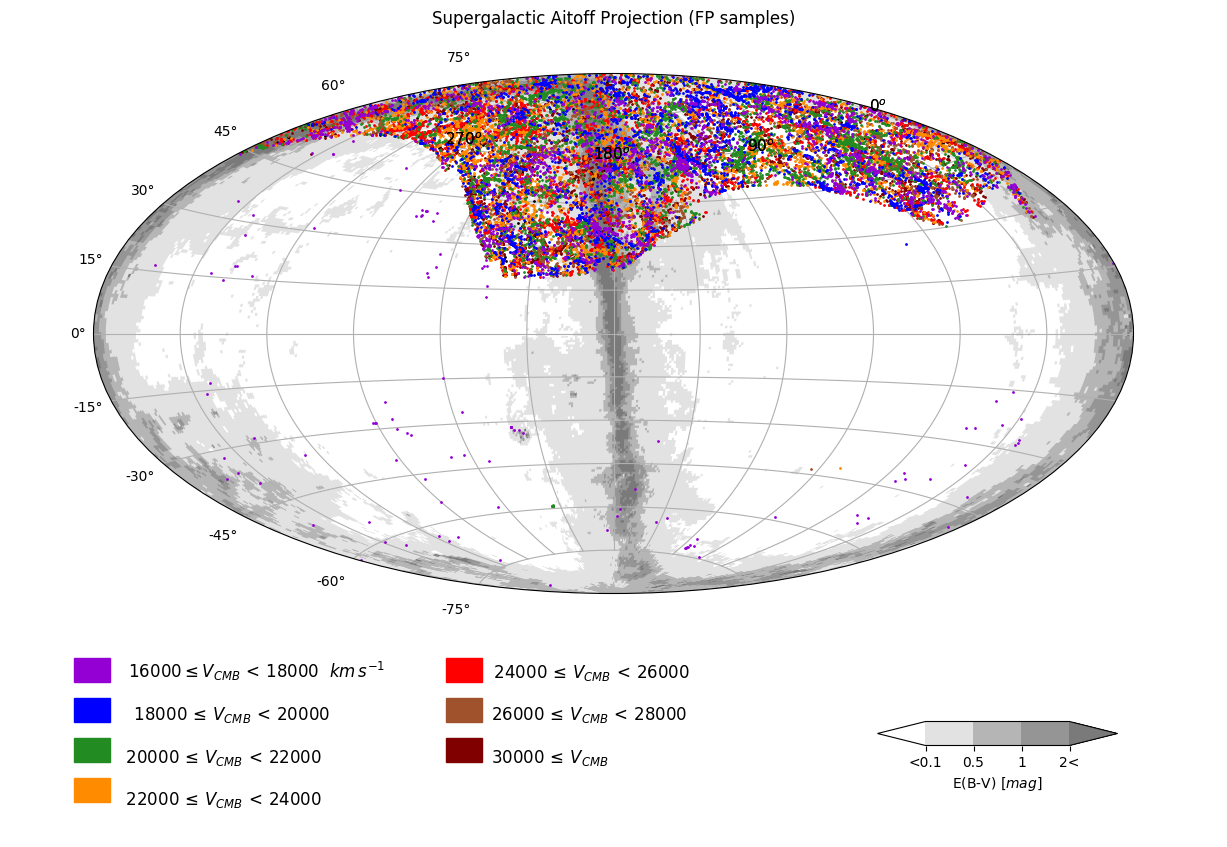

In [39]:
l0 = 180

deg = 0.8
a = pyfits.open('EBV.0.8.deg.fits')
d = a[1].data


SGL  = d['SGL']
SGB  = d['SGB']
EBV = d['EBV']

fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection="aitoff")
plt.title("Supergalactic Aitoff Projection (FP samples)", y=1.08)
ax.grid(True)
ax.set_xticklabels([])
plt.subplots_adjust(top=0.95, bottom=0.3, right=0.95, left=0.05)

ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')


ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')  
################################################################ 
################################################################ 
def xymap_aitoff(x, y):
  
    while x > 360:
        x-=360
    while x < 0:
        x+=360

    x0 = (180.-x)*pi/180.
    y0 = y*pi/180.
  
    return x0, y0
################################################################ 

def esn_aitoff_patch(ax, x0, y0, d, color='blue'):

    vertices = []
    x, y = xymap_aitoff(x0,y0) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0) 
    vertices.append([x,y]) 
    ax.add_patch(Polygon(vertices, closed=True, fill=True, color=color))


jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(len(SGB)):
    if EBV[i]>2.0: val = 3
    elif EBV[i]>1.0: val = 2.5
    elif EBV[i]>0.5: val= 2.0
    elif EBV[i]<=0.5 and EBV[i]>0.1: val= 1.0
    elif EBV[i]<0.1: val= 0
    else: val= 0
    colorVal = scalarMap.to_rgba(val)
    esn_aitoff_patch(ax, SGL[i], SGB[i], deg, color=colorVal)

    
    
# N = len(SGL)
# X = np.zeros(N)
# Y = np.zeros(N)
# for i in range(N):
#     X[i], Y[i] = xymap_aitoff(SGL[i], SGB[i])    
# ax.scatter(X, Y, marker='.', color='black')


sgl_gal = df.sgl.values
sgb_gal = df.sgb.values
N = len(sgl_gal)
X = np.zeros(N)
Y = np.zeros(N)
for i in range(N):
    X[i], Y[i] = xymap_aitoff(sgl_gal[i], sgb_gal[i])
    
############################################
    
# vel_col = np.zeros(N)   
# Velocity = df.Vcmb.values
# for i, v in enumerate(vel):
#     vel_col[i] = 0
#     if v<=0:
#         vel_col[i] = 0.1
#     elif v>=11000:
#         vel_col[i] = 1
#     else:
#         vel_col[i] = 0.1+0.9*v/11000.
    
# colours = pl.cm.nipy_spectral(vel_col)

############################################
col_pallet = ['darkviolet', 'blue', 'forestgreen',  
              'darkorange', 'red', 'sienna', 'maroon', 'black']
vel_pallet = [16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000, 40000]
def color_table(Velocity):
    colours = []
    for j, v in enumerate(Velocity):
        col = "white"
        for i in range(len(vel_pallet)-1):
            if vel_pallet[i] <= v and v < vel_pallet[i+1]:
                col = col_pallet[i]
                break
        colours.append(col)
    return colours

colours = color_table(df.Vgrp.values)
############################################

ax2 = plt.axes([0,0,1,1], facecolor=(1,1,1,0))
ax2.set_axis_off()
ax2.set_xticks([])
ax2.set_yticks([])
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.annotate(r"$\/\/ 16000 \leq V_{CMB} \/ < \/ 18000 \/\/\/\/ km\/ s^{-1}  $", (0.1,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$ \/\/\/\/ 18000 \/ \leq \/ V_{CMB} \/ < \/ 20000$', (0.1,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 20000 \/ \leq \/ V_{CMB} \/ < \/ 22000$', (0.1,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 22000 \/ \leq \/ V_{CMB} \/ < \/ 24000$', (0.1,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 24000 \/ \leq \/ V_{CMB} \/ < \/ 26000$', (0.40,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$26000 \/ \leq \/ V_{CMB} \/ < \/ 28000$', (0.40,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$30000 \/ \leq \/ V_{CMB}$', (0.40,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')

try:
    p = 0
    for m in [0.1,0.41]:
        for n in [0.19,0.19-0.05,0.19-2*0.05,0.19-3*0.05]:
            ax2.add_patch(patches.Rectangle((m-0.05, n), 0.03, 0.03, color=col_pallet[p]))
            p+=1
            if p==7:
                break
        
    # ax2.add_patch(patches.Rectangle((0.71-0.05, 0.19), 0.03, 0.03, color=col_pallet[p]))
except:
    pass
############################################
################################################################ 
jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
ax3 = fig.add_axes([0.720, 0.11, 0.2, 0.03])
cols = []
bounds = [0,1,2,3]
#cols.append(scalarMap.to_rgba(0))
cols.append(scalarMap.to_rgba(1.0))
cols.append(scalarMap.to_rgba(2.0))
cols.append(scalarMap.to_rgba(2.5))
#cols.append(scalarMap.to_rgba(3.0))



cm = colors.ListedColormap(cols)

cm.set_over(scalarMap.to_rgba(3.0))
cm.set_under(scalarMap.to_rgba(0))

cNorm  = colors.BoundaryNorm(bounds, cm.N)
cbar = colorbar.ColorbarBase(ax3, cmap=cm, norm=cNorm, orientation='horizontal',ticks=bounds, boundaries=[-1]+bounds+[4],extend='both',extendfrac='auto')
cbar.set_ticks(bounds)
cbar.ax.tick_params(labelsize=10) 
cbar.ax.set_xticklabels(['<0.1','0.5','1','2<'])  # horizontal colorbar

cbar.set_label('E(B-V) '+r'$[mag]$')
################################################################   

for i, c in enumerate(colours):
    ax.plot([X[i]], [Y[i]], color=c, marker='.', ms=2)
    